In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

100%|██████████| 9.91M/9.91M [00:00<00:00, 50.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.79MB/s]


Epoch 1 completed
Epoch 2 completed
Surrogate Accuracy: 0.41


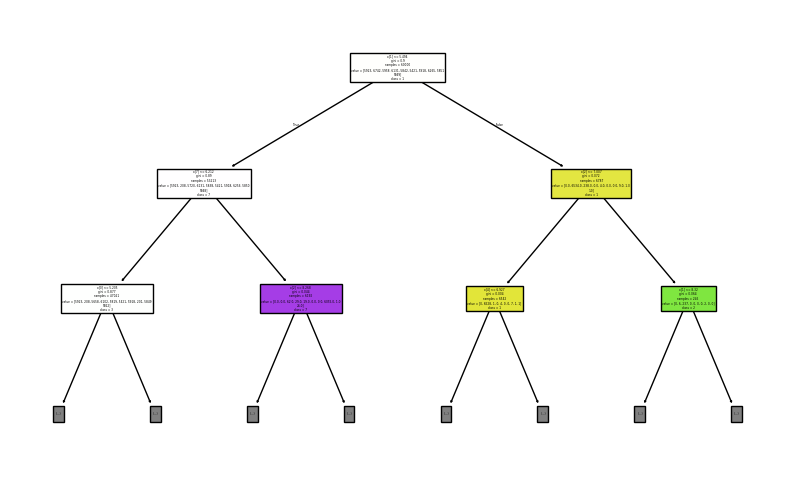

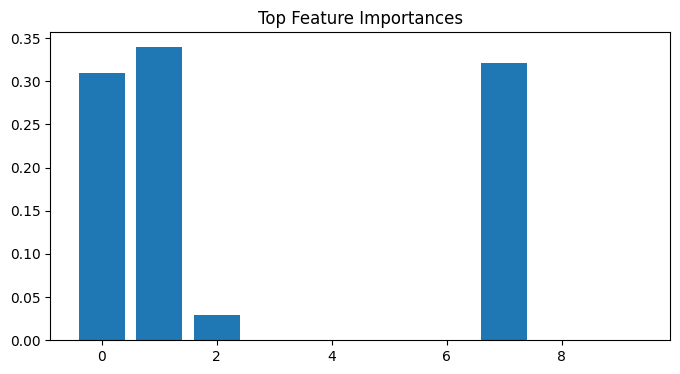

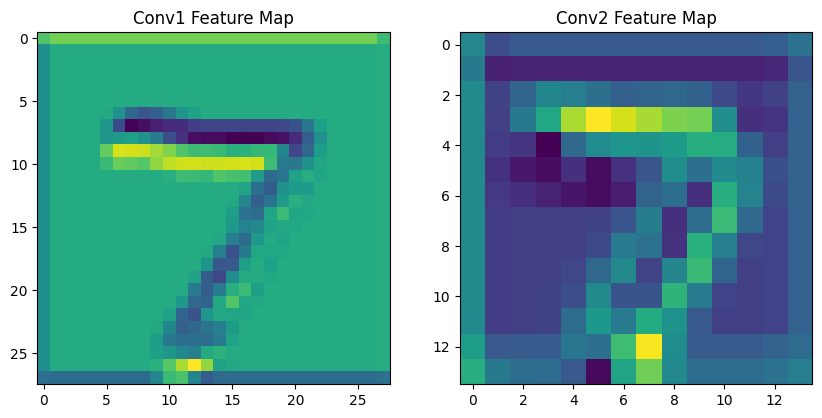

In [12]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Define CNN model using functional components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1).to(device)
conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1).to(device)
fc1 = nn.Linear(32 * 7 * 7, 128).to(device)
fc2 = nn.Linear(128, 10).to(device)

# Forward function
def forward(x):
    x = F.max_pool2d(F.relu(conv1(x)), 2)
    x = F.max_pool2d(F.relu(conv2(x)), 2)
    x = F.relu(fc1(x.view(-1, 32 * 7 * 7)))
    return fc2(x)

# Setup optimizer
parameters = list(conv1.parameters()) + list(conv2.parameters()) + list(fc1.parameters()) + list(fc2.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train CNN
for epoch in range(2):
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = forward(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} completed")

# Extract features for surrogate model
X_train, y_train = [], []
X_test, y_test = [], []

with torch.no_grad():
    for images, labels in trainloader:
        outputs = forward(images.to(device))
        X_train.extend(outputs.cpu().numpy())
        y_train.extend(labels.numpy())

    for images, labels in testloader:
        outputs = forward(images.to(device))
        X_test.extend(outputs.cpu().numpy())
        y_test.extend(labels.numpy())

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Train decision tree surrogate
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
print(f"Surrogate Accuracy: {dt.score(X_test, y_test):.2f}")

# Visualize decision tree
plt.figure(figsize=(10, 6))
plot_tree(dt, filled=True, max_depth=2, class_names=[str(i) for i in range(10)])
plt.show()

# Feature importance
plt.figure(figsize=(8, 4))
plt.bar(range(10), dt.feature_importances_[:10])
plt.title("Top Feature Importances")
plt.show()

# Visualize feature maps
def get_feature_maps(image):
    img = image.unsqueeze(0).to(device)
    with torch.no_grad():
        c1_out = conv1(img)
        c2_out = conv2(F.max_pool2d(F.relu(c1_out), 2))

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(c1_out[0, 0].cpu().numpy(), cmap='viridis')
    ax[0].set_title("Conv1 Feature Map")
    ax[1].imshow(c2_out[0, 0].cpu().numpy(), cmap='viridis')
    ax[1].set_title("Conv2 Feature Map")
    plt.show()

get_feature_maps(testset[0][0])